# Bayesian Hyperparameter Optimisation

### Authors: Petar Tonchev, Mariya Mladenova and Osman Deger

> In this notebook we implement basic bayesian optimisation framework and test it on several objective functions.

We first strat by defining a test problem to build the bayesian optimisation framework.

We would like to maximize a multimodal problem with a few peaks defined by the following function:

$$ y= x \sin(10\pi x)^3$$


We picked such a function since it has multiple local optimum points but it's easy to visualize the entire function.

We alter the orignial function by adding Gaussian noise in order to make the objective function more challenging to optimize.

### **Test Problem**

In [3]:
# Basic Imports
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [4]:
# toy problem objective function:
# We add noise as a paramter in order to control how much noise we want
def objective(x, noise=0.1):
    noise = stats.norm.rvs(loc=0, scale=noise)
    return (x * np.sin(10 * np.pi * x)**3) + noise

Now, let's create a grid to evaluate the objective function and display it to get more sense how it looks like.

In [5]:
grid = np.arange(0, 1, 0.01)

y = [objective(x, 0) for x in grid]
y_noise = [objective(x) for x in grid]

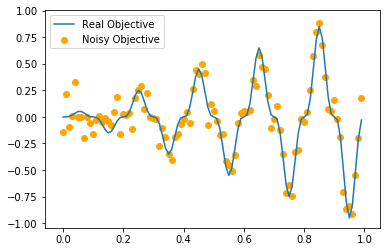

In [82]:
plt.plot(grid, y, label='Real Objective')
plt.scatter(grid,y_noise, label='Noisy Objective', c='orange')
plt.legend()
plt.savefig('noisy_objective.png')
plt.show()


In [7]:
# The global maximum of the function in the given domain is:
ix = np.argmax(y)
print('The true maximum is: x=%.3f, y=%.3f' % (grid[ix], y[ix]))

The true maximum is: x=0.850, y=0.850


In a real-world scenario we wouldn't know this objective function but it is helpful to have it in order to confirm that the bayesian optimization is working correctly.

**Surrogate Function**

The surrogate function summarizes the conditional probability of the objective function $f$ given the data $D$: $$P(f|D)$$

The most popular technique to do this is to treat the problem as a regression with the data representing the input and the score representing the output of the model. This is very often done using a Gaussian Process since it gives a posterior distribution over the modeled objective function that is analytically tractable. 


In the scikit learn library, we can quickly evaluate points on it by invoking the `predict` method and sample from the posterior distribution using the `sample_y` method.



In [8]:
import sklearn.gaussian_process as gp

This function can cause warnings if the distribution is thin at a given point we are interested in sampling so we ignore the warnings

In [9]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def surrogate_function(gp, X):
    """
    The surrogate function is a gaussian process regressor that is
    trained on previous observations.
    """
    return gp.predict(X, return_std=True)

**Acquisition Function**

Now let's define the acqusition function to use it as a sampling strategy.

The acquisition function is used as a heuristic that scores the points how good they are to be evaluated next. Then, having the acquisition function we take the point with the highest score.

For this test problem we pick the simplest acquisition function, that is **Probability of Improvement**. It chooses the next query point to be the one that has the highest probability of improvement over the known best point so far.  

$$ PI = \Phi\left (\frac{\mu - \mu_{best}}{\sigma + \epsilon}\right),$$ where $\Phi$ is the cdf of a normal distribution, $\mu$ and $\sigma $ are the mean and std. deviation of the surrogate function for a given $x$ and  $\mu_{best}$ is the mean of the surrogate function for the best sample found so far. The $\epsilon$ is a very small value added to avoid division by 0.

To get the next query point we just need to take the max of PI:

$$ x_{t+1} = argmax_x(PI(x))$$

In [10]:
def pi_acquisition(x, gp, mu_best, maximize=True):
    n_paramters = x.shape[0]
    x = x.reshape(-1, n_paramters)

    mu, std = surrogate_function(gp, x)
    mu = mu[:, 0]
    
    PI = (stats.norm.cdf((mu - mu_best) / (std + 1e-10)))
    
    if maximize:
        return -1 * PI
    else:
        return PI

To optimize it we would use the minimize function from scipy

In [11]:
from scipy.optimize import minimize

def opt_acquisition(y, gp, bounds):
    
    strating_point = np.random.uniform(low=bounds[0], high=bounds[1], size=1)  
    
    result = minimize(fun=pi_acquisition,
                      x0=strating_point, 
                      bounds=np.array([bounds]), # the bounds need to be in 2d array
                      args=(gp, np.max(y)))      # the additional arguments needed for the acquisition function
    
    return result.x
        

Now we put all together:

We create a function that performs the bayesian optimisation algorithm.
 It first evaluates the objective function at several random points and put them in the GaussianProcess model in order to generate the posterior.

Then we can evaluate the posterior using the `surrogate` function in order to explore its surface end select the next position to evaluate the `objective` using the best point according to the **aquisition function**.

In this simple case we would assume we want to maximize the objective function so we would hard-code it into the function. Moreover, to stick to the simplest case we would stick with one-dimensional hyperparameter optimization. We would expand the function later to be able to cope with more than 1 dimensions.

In [12]:
def bayesian_optimisation(objective, hp_bounds=[0,1.], n_iter=100, n_start_points=5):
    """
    Uses Gaussian Processes to maximize the objective function `objective`.
    Arguments:
    ----------
        objective: function
            Function to be maximized
        hp_bounds: array-like with shape of 2
            The lower and upper bounds of the hyper parameters
        n_iter: integer, default=100
            The budget - the number of iterations to run the algorithm for
        n_start_points: integer, default=5
            The number of initial random evaluations of the objective function before we run the algorithm
    """    
    
    # Get the hyperparameter bounds 
    lower_bound = hp_bounds[0]
    upper_bound = hp_bounds[1]
        
    # Sample uniformly from the domain 
    x = np.random.uniform(low=lower_bound, high=upper_bound, size=n_start_points)
    y = np.array([objective(parameter) for parameter in x])
    
    # Reshape them in the form of a dataset in order to use them in the sklearn gp model
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    
    # Create the surrogate function using gaussian processes regressor
    model = gp.GaussianProcessRegressor(normalize_y=True, n_restarts_optimizer=10)
    
    for i in range(n_iter):
        
        # Fit the data into the surrogate function to model the objective function
        model.fit(x,y)
        
        # Select the next best point to evaluate the objective on
        x_new = opt_acquisition(y, model, hp_bounds)
        
        # Evaluate objective using the new point
        y_new = objective(x_new)
        
        # Update the data in order to update the model on the next iteration
        x = np.vstack((x, [x_new]))
        y = np.vstack((y, [y_new]))
        
        
    # Store the best results we have so far in order to update them
    idx_best = np.argmax(y)
    x_best = x[idx_best]
    y_best = y[idx_best]

    
    return {
        'best': {'y': y_best, 'x': x_best}, 
        'history': {'x': x, 'y': y},
        'model': model
    }

In [13]:
out = bayesian_optimisation(objective, n_iter=50)

In [14]:
out['best']

{'y': array([0.89770969]), 'x': array([0.8471494])}

Let's observe the results visually.

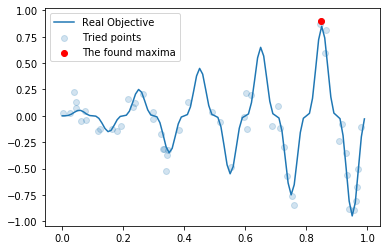

In [15]:
y = [objective(x, 0) for x in grid]
plt.plot(grid, y, label='Real Objective')
plt.scatter(out['history']['x'], out['history']['y'],alpha=0.2, label='Tried points')
plt.scatter(out['best']['x'],out['best']['y'],c='r', label='The found maxima')


plt.show()

In [16]:

print('True Maximum: x=%.3f, y=%.3f' % (grid[ix], y[ix]))
print('Found Maximum: x=%.3f, y=%.3f' % ( out['best']['x'],out['best']['y']))


True Maximum: x=0.850, y=0.850
Found Maximum: x=0.847, y=0.898


So it was able to find the hyperparameter value that maximizes the noisy objective function with very small error. The difference in the actual value of the objective function is due to the noisy evaluation that we have integrated into the `objective` method.

### Improving the Framework

Now that we have the framework build on this simple problem we would like to make several changes to improve it to be more flexible:

1. We are going to implement support for multi-dimensional hyperparameter optimization. To do this we would alter the `bayesian_optimization` and `opt_acquisition` functions.

2. We would add a paramter `custom_acqusition_opt_function` since not every acquisition is appropriate to optimize with `opt_acqusition` function.

3. We would alter the `opt_acqusition` to recieve the actual acqusition function as a parameter in order to experiment with other acquistion functions
4. We would like to seed the `bayesian_optimization` runs with initial points so that we can compare how different acqusition functions perform starting from the same position.

### _______
We first start from `opt_acqusition`:

1. We add additional paramter `acquisition_function`
1. We change the starting point to support multi-dimensional hyperparameters whose dimension is specified by the paramter `n_params`

In [17]:
from scipy.optimize import minimize

def opt_acquisition(y, gp, bounds, acquisition_function, n_params=1, maximize=True):
    
    # We change the way we were getting the bounds and the shape of the output
    strating_point = np.random.uniform(low=bounds[:,0], high=bounds[:,1], size=(1, n_params))  
    
    result = minimize(fun=acquisition_function,
                      x0=strating_point, 
                      bounds=bounds,
                      args=(gp, np.max(y), maximize)) # the additional arguments needed for the acquisition function
    return result.x

Next we proceed to the `bayesian_optimization` function in which we have to integrate the changes we made above:

In [146]:
from sklearn.gaussian_process.kernels import Matern

def bayesian_optimisation(objective,
                          acquisition,
                          custom_acqusition_opt_function=None,
                          hp_bounds=np.array([[0,1.]]),
                          n_iter=100,
                          initial_points=None,
                          n_start_points=5,
                          maximize=True):
    """
    Uses Gaussian Processes to maximize the objective function `objective`.
    Arguments:
    ----------
        objective: function
            Function to be maximized
        acquisition: function
            The acquisition function
        custom_acqusition_opt_function: function
            A custom acquisition optimization function if the default one `opt_acquisiton` is not appropraite
        hp_bounds: array-like with shape of 2
            The lower and upper bounds of the hyper parameters
        n_iter: integer, default=100
            The budget - the number of iterations to run the algorithm for
        initial_points: np.array
            The initial points to run the algorithm with, if not specified `n_start_points` are drawn at random  
        n_start_points: integer, default=5
            The number of initial random evaluations of the objective function before we run the algorithm
        maximize: boolean
            Whether the objective have to maximized or minimized
    """    
    
    n_params = hp_bounds.shape[0]
    
    choose_next_query_point = opt_acquisition if custom_acqusition_opt_function is None else custom_acqusition_opt_function 
   
    # Get the hyperparameter bounds 
    lower_bounds = hp_bounds[:,0]
    upper_bounds = hp_bounds[:,1]
        
    if initial_points is None: 
        # Sample uniformly from the domain 
        x = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(n_start_points, n_params))
    else:
        x = initial_points.copy()
        
    y = np.array([objective(parameter) for parameter in x])
    
    # Reshape them in the form of a dataset in order to use them in the sklearn gp model
    x = x.reshape(-1, n_params)
    y = y.reshape(-1, 1)
        
    
    # Create the surrogate function using gaussian processes regressor
    K = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
    model = gp.GaussianProcessRegressor(kernel=K)
    
    for i in range(n_iter):
        
        # Fit the data into the surrogate function to model the objective function
        model.fit(x,y)
        
        # Select the next best point to evaluate the objective on
        x_new = choose_next_query_point(y, model, hp_bounds, acquisition, n_params, maximize)
        
        # Evaluate objective using the new point
        y_new = objective(x_new)
        
        # Update the data in order to update the model on the next iteration
        x = np.vstack((x, [x_new]))
        y = np.vstack((y, [y_new]))
        
        
    # Store the best results we have so far in order to update them

    idx_best = np.argmax(y) if maximize else np.argmin(y)
    x_best = x[idx_best]
    y_best = y[idx_best]

    
    return {
        'best': {'y': y_best, 'x': x_best}, 
        'history': {'x': x, 'y': y},
        'model': model
    }

In [79]:
out = bayesian_optimisation(objective, pi_acquisition, n_iter=30)

In [80]:
out['best']

{'y': array([0.92969045]), 'x': array([0.85055822])}

### More Acqusition Functions

Now that we know the framework works, let's implement with some more acqusition functions. 

#### **Probability of Improvement**.

We have already defined the *Probability of Improvement* acquisition function. However, we can improve it by adding a parameter that controls the exploration-exploitation balance of the acqusition function. 

By changing the function to be:

$$ PI = \Phi\left (\frac{\mu - \mu_{best} - \lambda}{\sigma + \epsilon}\right),$$ 
where $\lambda$ is the exploitation-exploitation parameter. The lower the $\lambda$, the more we exploit the best paramteres so far so it should sample points around it. The higher, the $\lambda$, the more it samples points with high uncertainty.

In [62]:
def pi_acquisition2(x, gp, mu_best, maximize=True, lamb=0.05):
    n_paramters = x.shape[0]
    x = x.reshape(-1,n_paramters)
    mu, std = surrogate_function(gp, x)
    
    PI = (stats.norm.cdf((mu - mu_best - lamb) / (std + 1e-10)))
    
    if maximize:
        return -1 * PI
    else:
        return PI

#### **Expected Improvement**

While the probability of improvement consides **how probable** is the query point to improve the best, the Expected Improvement takes into account **how much** it can improve the best.

Thus, the strategy is to pick the candidate point with the highest expected improvement over the current best point:

$$EI(x) = \mathop{\mathbb{E}} max(f(x) - f(x^*), 0) $$

Fortunately, there is an analytical expression of the above formula under the GaussianProcesses model:

$$
EI(x) =
\begin{cases}
    (\mu(x) - f(x^*) - \lambda) \Phi(Z) + \sigma_t(x) \phi(Z) ,& \text{if } \sigma(x) > 0 \\
    0,              & \text{if} \sigma(x) = 0
\end{cases}
$$

$$Z = \frac{\mu_t(x) -f(x^*) - \lambda}{ \sigma + \epsilon}$$

where $\Phi$ is the CDF and $\phi$ is the pdf of a normal distribution, $\lambda$ is exploration paramter and $\epsilon$ is added to avoid division by zero.

The EI value can be high in either of the two cases:
1. The expected value is high $(\mu(x) - f(x^*) - \lambda)$
2. The uncertainty $\sigma_t(x)$ is high

In [63]:
def ei_acqusition(x, gp, mu_best, maximize=True, lamb=0.05):
    n_paramters = x.shape[0]
    x = x.reshape(-1,n_paramters)
    
    mu, std = surrogate_function(gp, x)
    
    improvement = (mu - mu_best - lamb)
    Z = improvement / (std + 1e-10) # epsilon is hardcoded 
    
    EI = improvement * stats.norm.cdf(Z) + std * stats.norm.pdf(Z)
    
    if maximize:
        return -1 * EI
    else:
        return EI

#### **Thompson Sampling**

Another interesting acqusition function is Thompson Sampling. It involves sampling a function from the surrogate's posterior distribution and optimize it. The value that optimizes the sampled function is the next point that is evaluate by the objective. 

It involes *exploitation* since the sampled function surely passes through the current best point, thus, ensuring exploiting behaviour. However, on regions with high uncertainty the sampled function might appear to be of promising value so *exploration* is also encouraged by the algorithm.


Note that in order to reuse the code in `bayesian_optimisation` function without making it too complex we have to follow the same method signiture as `opt_acquisition`.

Therfore it is the following:

```python
def thompson_sampling_acqusition(y, 
                                 gp,
                                 bounds,
                                 acquisition_function=None,
                                 n_params=None,
                                 maximize=True):
```

even though we won't use `y`, `acquisition_function`, `n_params` paramters.

In [64]:
def thompson_sampling_acqusition(y, gp, bounds, acquisition_function=None, n_params=None, maximize=True):    
    # Make a grid on on which we should sample the posterior
    grid = np.linspace(bounds[:,0], bounds[:,1], 1000)
    
    # Sample a function from the posterior
    sampled_function = gp.sample_y(grid).T[0]
    
    # Pick the best point in this sampling
    if maximize:
        return grid[np.argmax(sampled_function)]
    else:
        return grid[np.argmin(sampled_function)]

## Visualising the algorithm:

We write a function that visualizes the objective function, the query points that the bayesian optimisation decided on, the best value it was able to find, the gaussian processes predicted mean function and the area of one standard deviation from the mean function representing the uncertainty:

In [171]:
def plot_bo_progress(title, objective, gp_model, grid, x_observed, y_observed, best_x, best_y, n_initial_points=None):
    plt.figure(figsize=[10,8], dpi=150)

    Y = objective(grid)
    # data

    y_mean, y_std = gp_model.predict(grid.reshape(-1, x_observed.shape[1]), return_std=True)
    y_mean=y_mean.flatten()

    # plotting
    plt.plot(grid, Y, 'k--', linewidth=2, label='Objective function');
    plt.plot(x_observed, y_observed, 'bo', label="""Query Points of the objective function""", alpha=0.7)
    plt.plot(grid, y_mean, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
    plt.plot(best_x, best_y, 'orange',ls="none", marker='*', ms=12,label='Optimal Point')
    
    if n_initial_points is not None:
        plt.plot(x_observed[:n_initial_points], y_observed[:n_initial_points], 'green',ls="none", marker='.', ms=12,label='Initial Points') 
    
    plt.fill_between(grid, y_mean - y_std, y_mean + y_std, alpha=0.2, color='r', label='Uncertainty')
    
#     plt.fill(np.concatenate([grid, grid[::-1]]),
#              np.concatenate([y_mean - 1.9600 * y_std,
#                         (y_mean + 1.9600 * y_std)[::-1]]),
#              alpha=.05, c='r', label='95% confidence interval')
    plt.xlabel('$x$');
    plt.ylabel('$f(x)$');
    plt.title(title)
    plt.legend(); 
    plt.savefig(title+'.png')
    plt.show();

### Experiments

We put a random seed to reproduce the experiments we are making

In [152]:
np.random.seed(412)

#### Experiment 1: The test problem 

We first explore the test problem we have defined above with the noisy objective function. It is challenging one since it's not convex and it is noisy. We would redefine it here to avoid confusion with the name of the function.

In [153]:
# toy problem objective function:
def noisy_toy_problem(x, noise=0.1):
    noise = stats.norm.rvs(loc=0, scale=noise)
    return (x * np.sin(10 * np.pi * x)**3) + noise

We draw 5 random initial points to run the bayesian algorithm with.

In [154]:
# The scope of the function is considered only the range of 0 to 1:
noisy_toy_problem_bounds = np.array([[0,1.]])
initial_x = np.random.uniform(low=0, high=1., size=(5, 1))

In [155]:
out_pi = bayesian_optimisation(noisy_toy_problem,
                              pi_acquisition2,
                              hp_bounds=noisy_toy_problem_bounds,
                              initial_points=initial_x,
                              maximize=True,
                              n_iter=30)

out_ei = bayesian_optimisation(noisy_toy_problem,
                               ei_acqusition,
                               hp_bounds=noisy_toy_problem_bounds,
                               initial_points=initial_x,
                               maximize=True,
                               n_iter=30)

out_ts = bayesian_optimisation(noisy_toy_problem,
                               acquisition=None,
                               custom_acqusition_opt_function=thompson_sampling_acqusition,
                               hp_bounds=noisy_toy_problem_bounds,
                               initial_points=initial_x,
                               maximize=True,
                               n_iter=30)

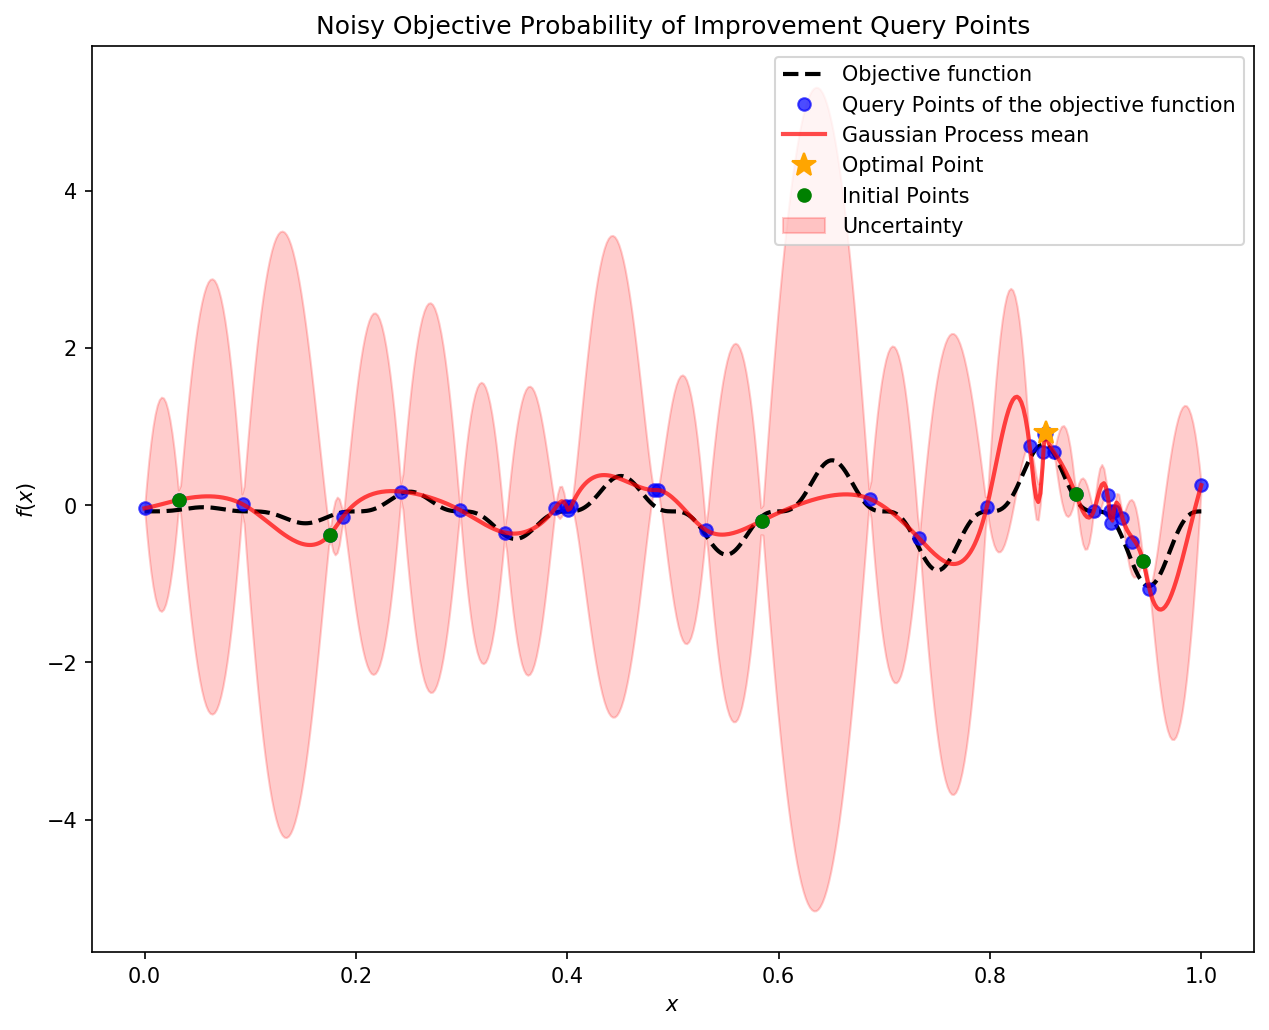

In [172]:
plot_bo_progress(title='Noisy Objective Probability of Improvement Query Points',
                 objective=noisy_toy_problem,
                 gp_model=out_pi['model'],
                 grid=np.linspace(0, 1, 500),
                 x_observed=out_pi['history']['x'],
                 y_observed=out_pi['history']['y'],
                 best_x=out_pi['best']['x'],
                 best_y=out_pi['best']['y'],
                 n_initial_points=5)

We observe that using the PI the optimal point is very close to the true maximum. It roughly got the correct shapeof the objective function except for the sector from 0.8 to 1 where it's too wiggly.

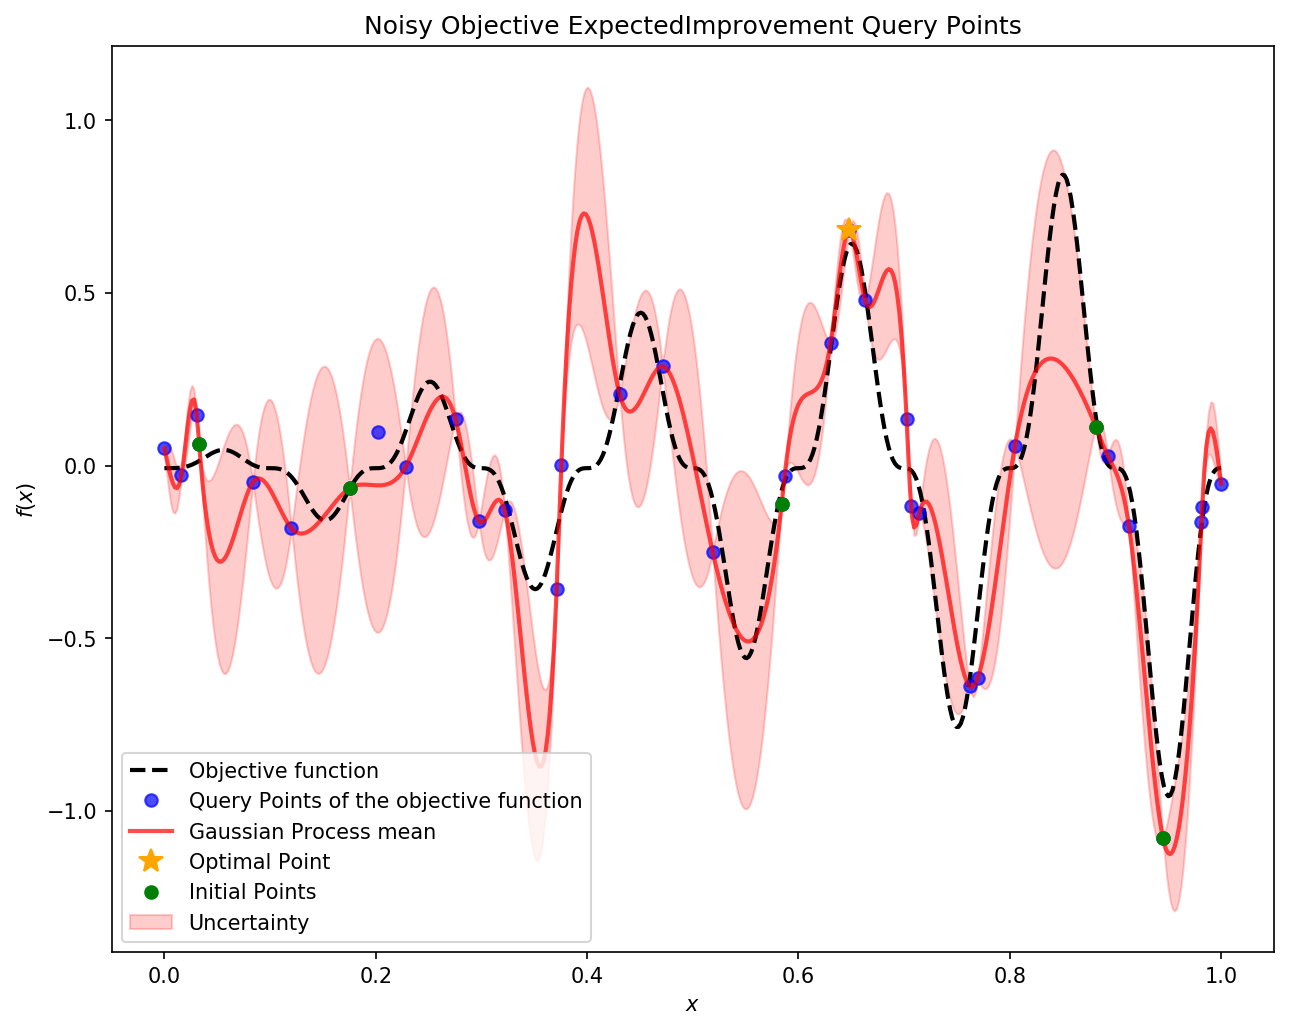

In [173]:
plot_bo_progress(title='Noisy Objective ExpectedImprovement Query Points',
                 objective=noisy_toy_problem,
                 gp_model=out_ei['model'],
                 grid=np.linspace(0, 1, 500),
                 x_observed=out_ei['history']['x'],
                 y_observed=out_ei['history']['y'],
                 best_x=out_ei['best']['x'],
                 best_y=out_ei['best']['y'],
                 n_initial_points=5
                )

EI results are worse since it failed to find the global maximum.

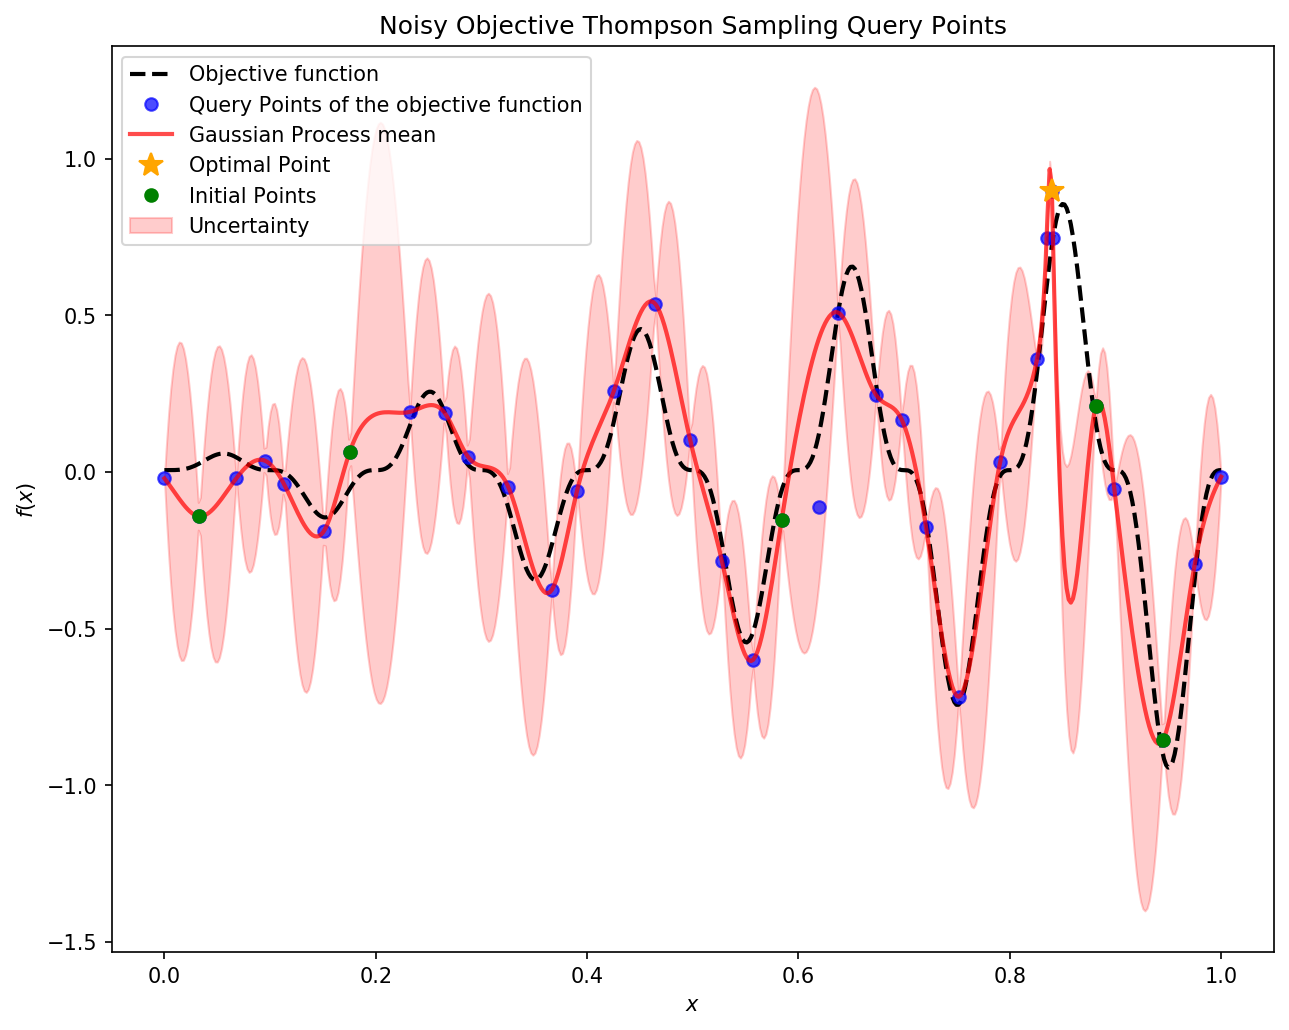

In [174]:
plot_bo_progress(title='Noisy Objective Thompson Sampling Query Points',
                 objective=noisy_toy_problem,
                 gp_model=out_ts['model'],
                 grid=np.linspace(0, 1, 500),
                 x_observed=out_ts['history']['x'],
                 y_observed=out_ts['history']['y'],
                 best_x=out_ts['best']['x'],
                 best_y=out_ts['best']['y'],
                 n_initial_points=5
                )

Thompson sampling has done really good job of almost fitting the real function and it got the maximim correct but not as close as PI

In [178]:
# The predicted best value of the noisy objective using thomspon sampling: 
print("True Maximum:", 0.850)
print("PI found:", out_pi['best']['x'])
print("EI found:", out_ei['best']['x'])
print("TS found:", out_ts['best']['x'])


True Maximum: 0.85
PI found: [0.85266857]
EI found: [0.64822028]
TS found: [0.83983984]


Both PI and TS are very close to the maximum.

Although, the results would differ a lot between runs we see that in this particular run PI and thompson sampling exploited more the found maximum and were able to get very close to the true maximum value of x=0.85.

#### Experiment 2: Ackley function 

Let's Make an experiment with another interesting objective function and avoid adding noise. We would like to find it's minimum in the range of -4 and 4 which is located at $x=0$ and $y=0$. 

In [214]:
np.random.seed(412)

In [182]:
# defining the function. At y=0 to get a 1D cut at the origin
def ackley_1d(x, y=0):
    out = (-20*np.exp(-0.2*np.sqrt(0.5*(x**2 + y**2))) 
           - np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y)))
           + np.e + 20)

    return out

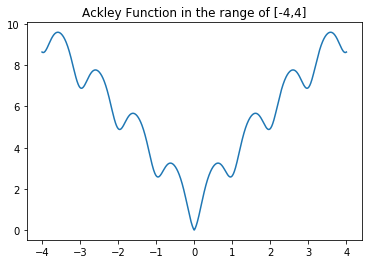

In [183]:
ackley_grid = np.linspace(-4,4, 1000)
plt.plot(ackley_grid, ackley_1d(ackley_grid))
plt.title("Ackley Function in the range of [-4,4]")
plt.savefig('ackley_func.png')
plt.show()

We would perform the experiment for 10 iterations with 5 randomly drawn points in the range from -4 to 4:

In [215]:
# The scope of the function is considered only the range of 0 to 1:
ackley_problem_bounds = np.array([[-4,4]])
initial_x = np.random.uniform(low=-4, high=4., size=(5, 1))

In [216]:
out_pi = bayesian_optimisation(ackley_1d,
                            pi_acquisition2,
                            hp_bounds=ackley_problem_bounds,
                            initial_points=initial_x,
                            maximize=False,
                            n_iter=10)

In [217]:
out_ei = bayesian_optimisation(ackley_1d,
                            ei_acqusition,
                            hp_bounds=ackley_problem_bounds,
                            initial_points=initial_x,   
                            maximize=False,
                            n_iter=10)

In [218]:
out_ts = bayesian_optimisation(ackley_1d,
                            acquisition=None,
                            custom_acqusition_opt_function=thompson_sampling_acqusition,
                            initial_points=initial_x,
                            hp_bounds=ackley_problem_bounds,
                            maximize=False,
                            n_iter=10)

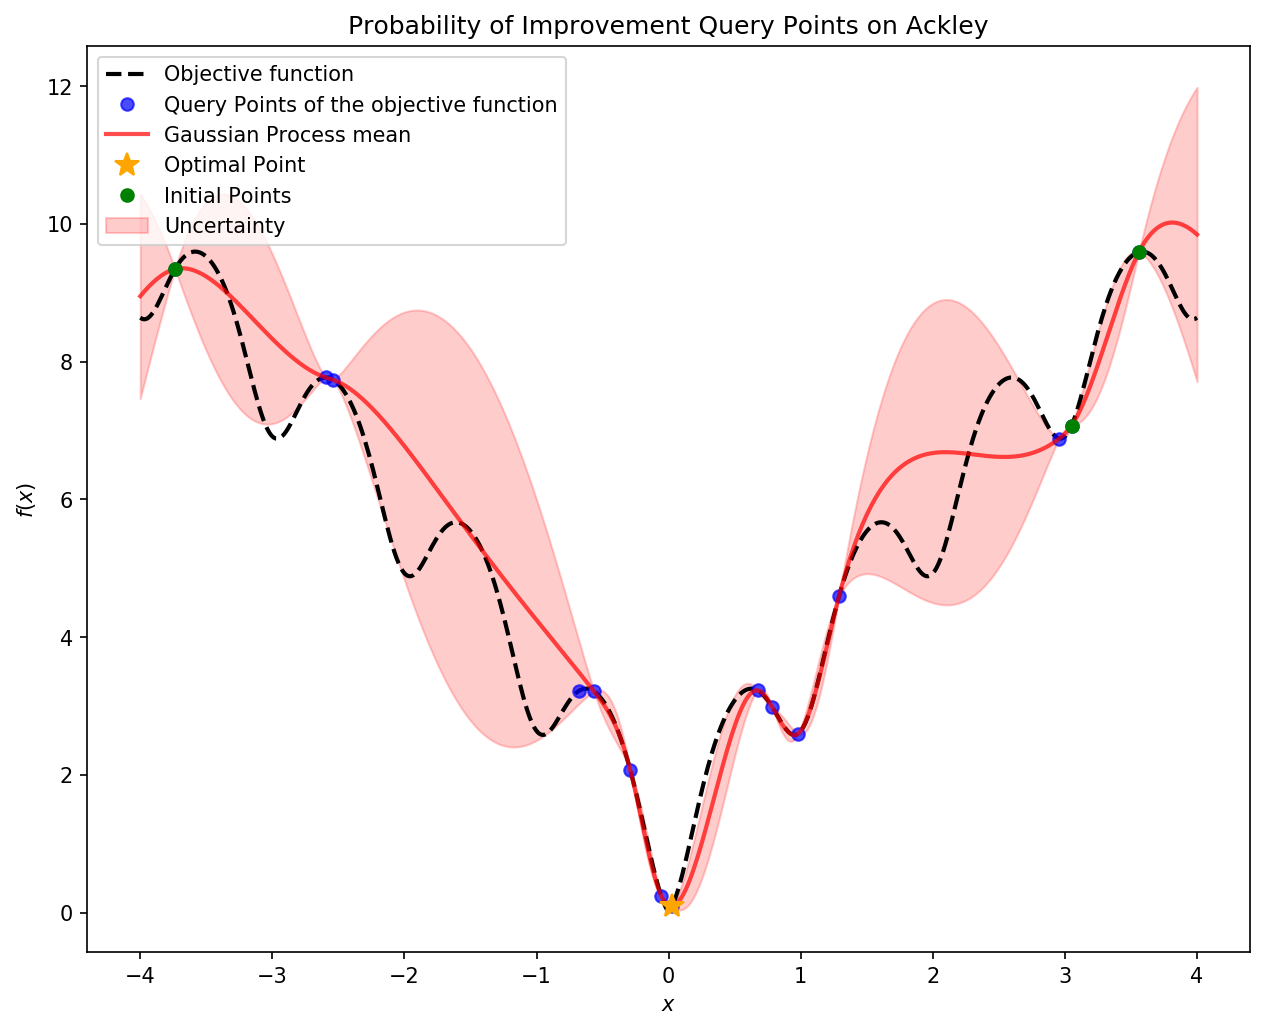

In [219]:
plot_bo_progress(title='Probability of Improvement Query Points on Ackley',
                 objective=ackley_1d,
                 gp_model=out_pi['model'],
                 grid=np.linspace(-4, 4, 500),
                 x_observed=out_pi['history']['x'],
                 y_observed=out_pi['history']['y'],
                 best_x=out_pi['best']['x'],
                 best_y=out_pi['best']['y'], 
                 n_initial_points=3
                )

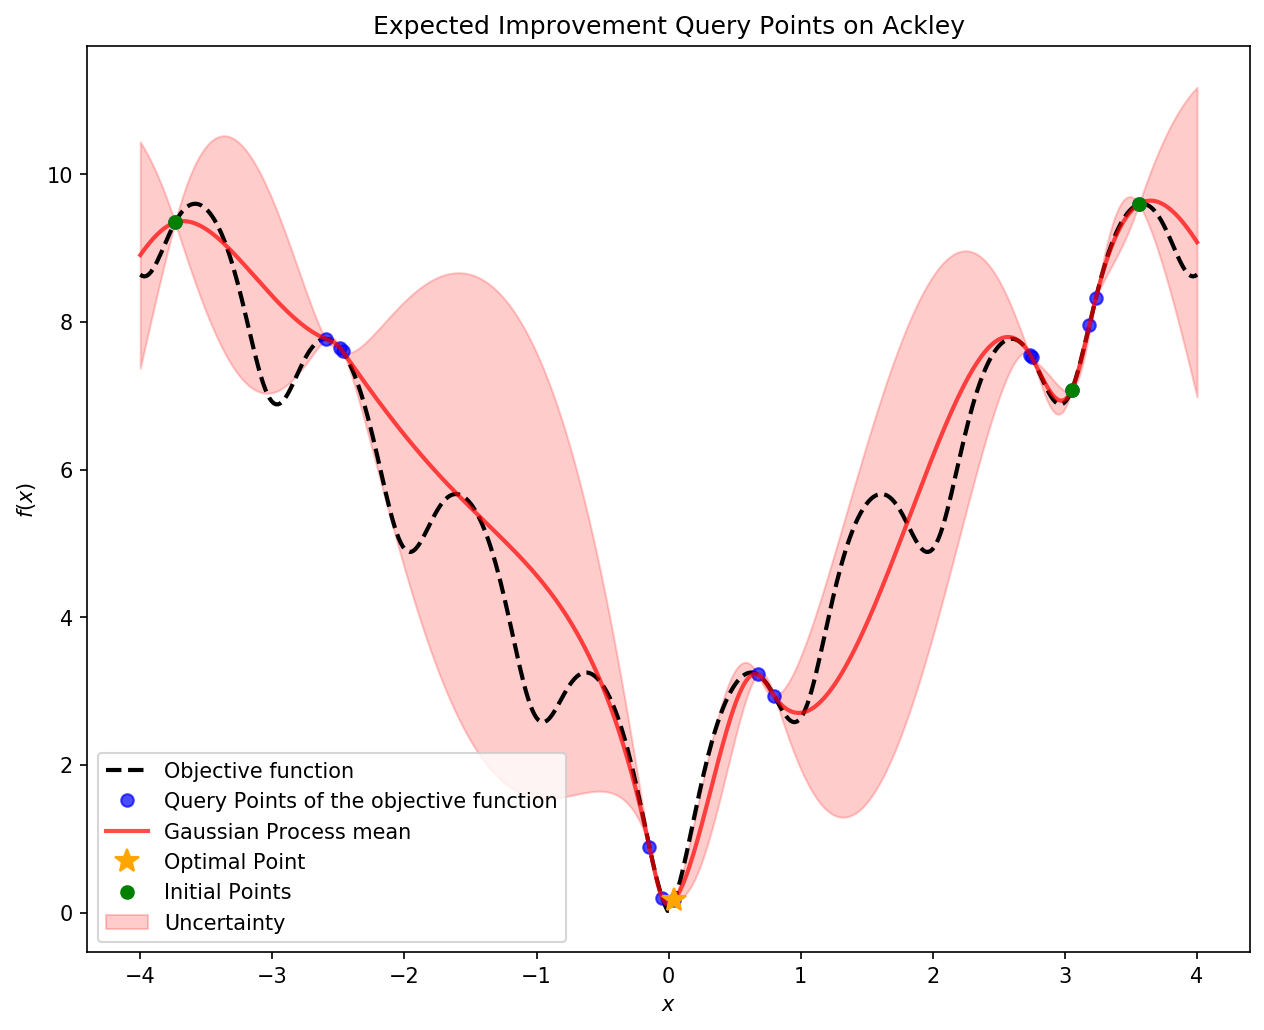

In [220]:
plot_bo_progress(title='Expected Improvement Query Points on Ackley',
                 objective=ackley_1d,
                 gp_model=out_ei['model'],
                 grid=np.linspace(-4, 4, 500),
                 x_observed=out_ei['history']['x'],
                 y_observed=out_ei['history']['y'],
                 best_x=out_ei['best']['x'],
                 best_y=out_ei['best']['y'],
                 n_initial_points=3
                )

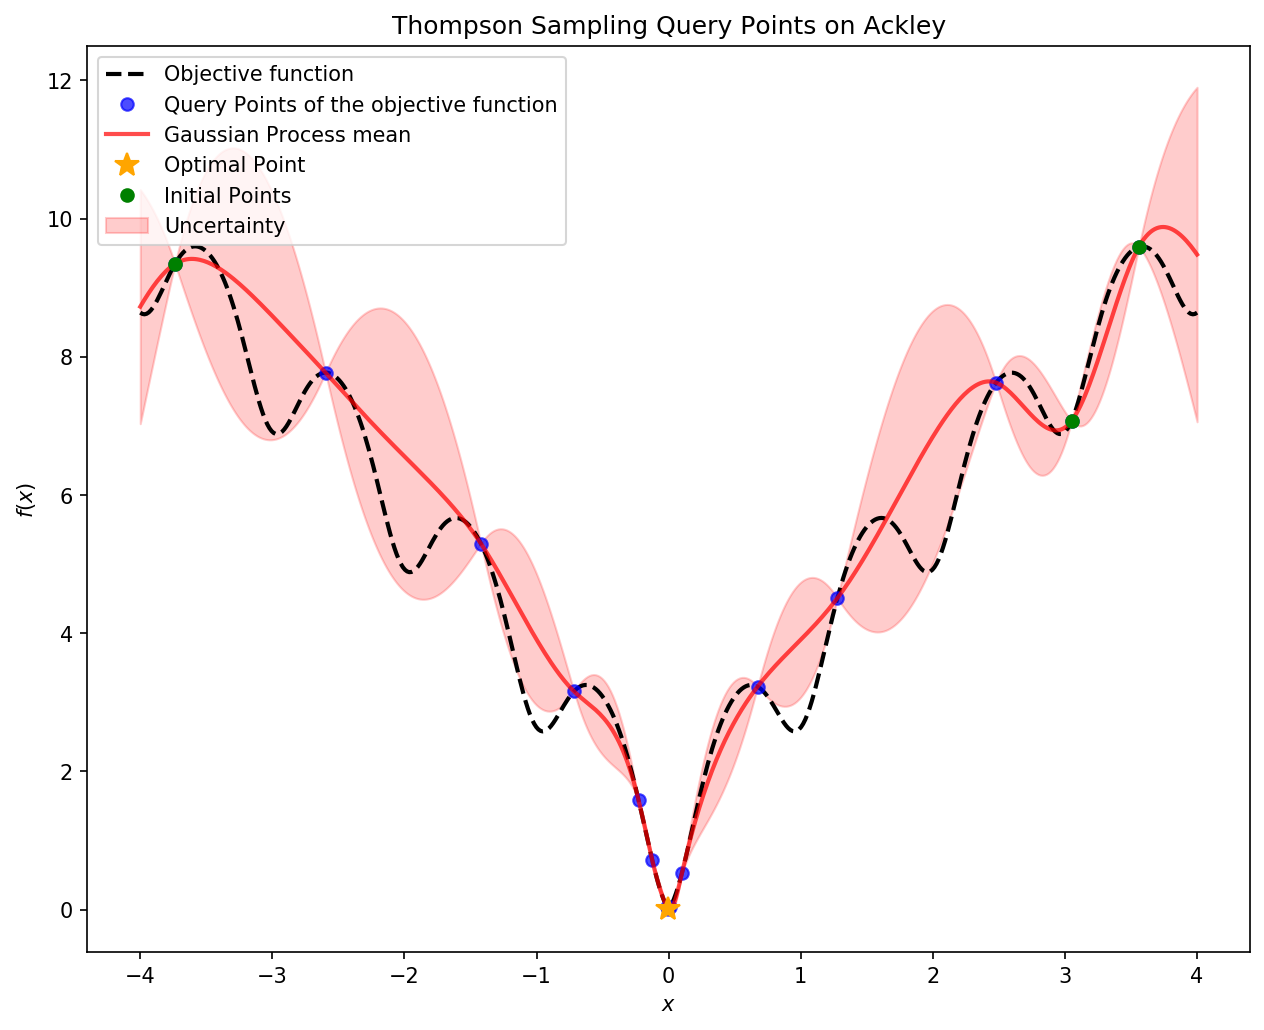

In [221]:
plot_bo_progress(title='Thompson Sampling Query Points on Ackley',
                 objective=ackley_1d,
                 gp_model=out_ts['model'],
                 grid=np.linspace(-4, 4, 500),
                 x_observed=out_ts['history']['x'],
                 y_observed=out_ts['history']['y'],
                 best_x=out_ts['best']['x'],
                 best_y=out_ts['best']['y'],
                 n_initial_points=3
                )

###### In this simpler function, every acquisition function was able to find the minimum. 

In [222]:
print("True Maximum:", 0)
print("PI found:", out_pi['best']['x'])
print("EI found:", out_ei['best']['x'])
print("TS found:", out_ts['best']['x'])

True Maximum: 0
PI found: [0.02660194]
EI found: [0.04304634]
TS found: [-0.004004]


#### Experiment 3. Classification Task

We would now create a classification dataset to test the bayesian optimisation on a real hyperparamter task.

For this we would use the `make_classification` function of `scikit-learn` to build a classification dataset:

In [38]:
from sklearn.datasets import make_classification

In [39]:
data, target = make_classification(n_samples=500,
                                   n_features=60,
                                   n_informative=15,
                                   n_redundant=5)

We would optimize an SVM's $C$ and $\gamma$ parameters. To do this the objective function would be a cross-validated ROC AUC score.

In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [41]:
class SVMObjective:
    def __init__(self, X_train, y_train):
        # store the train data 
        self.X_train = X_train
        self.y_train = y_train
        
    def roc_auc_score(self, params):
        return cross_val_score(SVC(C=10 ** params[0],
                                   gamma=10 ** params[1], 
                                   random_state=412),
                               X=self.X_train,
                               y=self.y_train,
                               scoring='roc_auc', cv=3).mean()
        

In [42]:
svm_objective = SVMObjective(data, target)

Since it's feasible to do grid search on this problem, let's make it in order to visualize the loss surface:

In [43]:
Cs = np.linspace(-4,1, 20)
gammas = np.linspace(-4,1, 20)
param_grid = np.array([[C, gamma] for gamma in gammas for C in Cs])

real_loss = [svm_objective.roc_auc_score(params) for params in param_grid]

In [44]:
# The maximum is at:
optimum_point = param_grid[np.array(real_loss).argmax(), :]
optimum_point

array([ 1.        , -2.42105263])

Let's visualise the objective function:

In [102]:
def plot_countor_of_real_loss():
    C, G = np.meshgrid(Cs, gammas)
    plt.figure()
    cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape), cmap='plasma')
    plt.colorbar(cp)
    plt.title('Contour plot of loss function')
    plt.xlabel('$C$')
    plt.scatter(optimum_point[0], optimum_point[1], marker='*', c='black', s=150, label='Optimum')
    plt.ylabel('$\gamma$')
    plt.legend()
    plt.show()

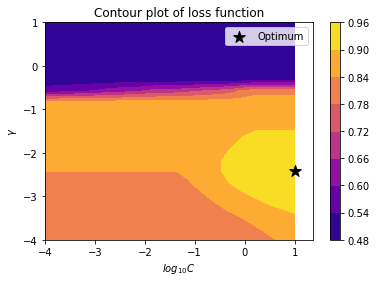

In [95]:
plot_countor_of_real_loss()

Moreover, we define a function that would display the mean estimate of the loss function that we obtain via the bayesian optimisation:

In [248]:
def plot_loss_2d(title, first_param_grid, second_param_grid, observed_x,gp, best_x, optimum=None, n_initial_points=5):

    param_grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])
    mu, std = gp.predict(param_grid, return_std=True)
    
    X, Y = np.meshgrid(first_param_grid, second_param_grid, indexing='ij')
    
    # Loss contour plot
    cp = plt.contourf(X, Y, mu.reshape(X.shape), cmap='plasma')
    plt.colorbar(cp)
    plt.autoscale(False)
    plt.scatter(observed_x[:, 0], observed_x[:, 1], zorder=1)
    plt.title(title)
    plt.xlabel("$C$")
    plt.ylabel("$\gamma$")

    plt.scatter(best_x[0], best_x[1], color='red', marker='p', label='Best found')
    
    if optimum is not None:
        plt.scatter(optimum[0], optimum[1], marker='*', c='black', s=150, label='Optimum')
        
    plt.scatter(observed_x[:n_initial_points, 0], observed_x[:n_initial_points, 1], marker='.', s=100, c='green', label='Initial Query Points')
    plt.legend()
    plt.savefig(title + '.png')
    plt.show()

In [224]:
np.random.seed(412)

We run the bayesian optimization for 10 iterations

In [225]:
# The scope of the function is considered only the range of 0 to 1:
classification_problem_bounds = np.array([[-4,1], [-4, 1]])
initial_x = np.random.uniform(low=-4, high=1., size=(5, 2))

In [228]:
out_pi = bayesian_optimisation(svm_objective.roc_auc_score,
                            pi_acquisition2,
                            hp_bounds=classification_problem_bounds,
                            maximize=True,
                            initial_points=initial_x,
                            n_iter=10)

In [229]:
out_ei = bayesian_optimisation(svm_objective.roc_auc_score,
                            ei_acqusition,
                            hp_bounds=classification_problem_bounds,
                            initial_points=initial_x,
                            maximize=True,
                            n_iter=10)

Since it's a 2d problem we change the thompson sampling to support 2d functions:

In [51]:
def thompson_sampling_acqusition_2d(y, gp, bounds, acquisition_function=None, n_params=None, maximize=True):    
    # Make a 2d grid on on which we should sample the posterior
    first_param_grid =  np.random.uniform(bounds[0,0], bounds[0,1], 10)
    second_param_grid =  np.random.uniform(bounds[1,0], bounds[1,1], 10)
    grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])
    
    # Sample a function from the posterior
    sampled_function = gp.sample_y(grid).T[0]
    
    # Pick the best point in this sampling
    if maximize:
        return grid[np.argmax(sampled_function)]
    else:
        return grid[np.argmin(sampled_function)]

In [231]:
out_ts = bayesian_optimisation(svm_objective.roc_auc_score,
                            acquisition=None,
                            custom_acqusition_opt_function=thompson_sampling_acqusition_2d,
                            hp_bounds=classification_problem_bounds,
                            initial_points=initial_x,
                            maximize=True,
                            n_iter=10)


Let's see the results starting from the **PI**:

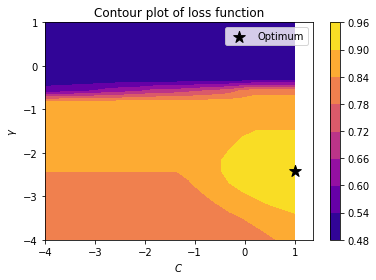

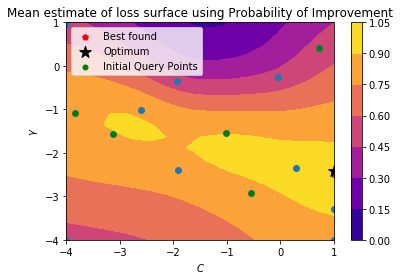

In [249]:
plot_countor_of_real_loss()

plot_loss_2d(title='Mean estimate of loss surface using Probability of Improvement',
             first_param_grid=Cs,
             second_param_grid=gammas,
             observed_x=out_pi['history']['x'],
             gp=out_pi['model'],
             best_x=out_pi['best']['x'],
             optimum=optimum_point)

We see that the mean estimate of where is the optimum point is very close

In [233]:
print("True Optimum point: \t", optimum_point)
print("Found optimum: \t\t", out_pi['best']['x'])
print()
print("True optimum value: \t", max(real_loss))
print("Found optimum value: \t", out_pi['best']['y'][0])

True Optimum point: 	 [ 1.         -2.42105263]
Found optimum: 		 [ 1.         -2.49153507]

True optimum value: 	 0.9441547025739215
Found optimum value: 	 0.9423304232420214


Results of **EI**

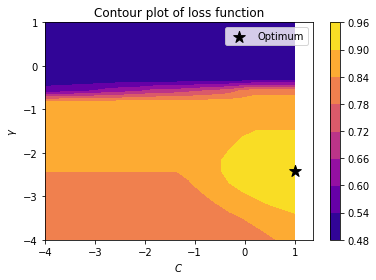

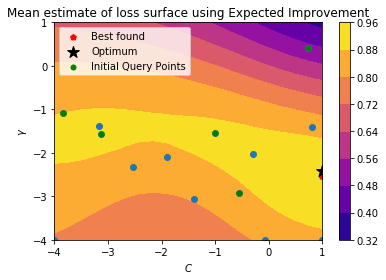

In [250]:
plot_countor_of_real_loss()

plot_loss_2d(title='Mean estimate of loss surface using Expected Improvement',
             first_param_grid=Cs,
             second_param_grid=gammas,
             observed_x=out_ei['history']['x'],
             gp=out_ei['model'],
             best_x=out_ei['best']['x'],
             optimum=optimum_point)

It could find the optimum as well as **PI** but the results are very close to the true optimum

In [235]:
print("True Optimum point: \t", optimum_point)
print("Found optimum: \t\t", out_ei['best']['x'])
print()
print("True optimum value: \t", max(real_loss))
print("Found optimum value: \t", out_ei['best']['y'][0])

True Optimum point: 	 [ 1.         -2.42105263]
Found optimum: 		 [ 1.         -2.53895486]

True optimum value: 	 0.9441547025739215
Found optimum value: 	 0.9410383933899684


**Thompson Sampling** results:

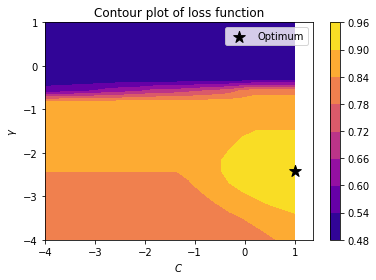

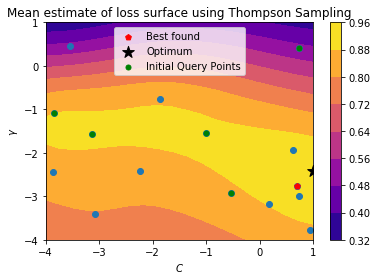

In [251]:
plot_countor_of_real_loss()

plot_loss_2d(title='Mean estimate of loss surface using Thompson Sampling',
             first_param_grid=Cs,
             second_param_grid=gammas,
             observed_x=out_ts['history']['x'],
             gp=out_ts['model'],
             best_x=out_ts['best']['x'],
             optimum=optimum_point)

In [252]:
print("True Optimum point: \t", optimum_point)
print("Found optimum: \t\t", out_ts['best']['x'])
print()
print("True optimum value: \t", max(real_loss))
print("Found optimum value: \t", out_ts['best']['y'][0])

True Optimum point: 	 [ 1.         -2.42105263]
Found optimum: 		 [ 0.69715683 -2.77377766]

True optimum value: 	 0.9441547025739215
Found optimum value: 	 0.9352700532479892


Again, it could really find the global maxima but it was  close